<a href="https://colab.research.google.com/github/adamMcneil/data-management-project/blob/main/598_mp4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
!{sys.executable} -m pip install h5py faiss-cpu requests scann
import faiss
import h5py
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import requests
import scann

SIFT1M_URL = "http://ann-benchmarks.com/sift-128-euclidean.hdf5"
SIFT1M_FILENAME = "sift-128-euclidean.hdf5"

In [ ]:
def download_sift1m():
    """Downloads the SIFT1M dataset if it's not already present."""
    if not os.path.exists(SIFT1M_FILENAME):
        print("Downloading SIFT1M dataset...")
        response = requests.get(SIFT1M_URL, stream=True)
        with open(SIFT1M_FILENAME, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print("Download complete.")
    else:
        print("SIFT1M dataset already exists.")

In [ ]:
def load_sift1m():
    with h5py.File("sift-128-euclidean.hdf5", "r") as f:
        train_data = np.array(f["train"], dtype=np.float32)
        test_queries = np.array(f["test"], dtype=np.float32)
        ground_truth = np.array(f["neighbors"], dtype=np.int64)[:, 0]
    print("Dataset loaded.")
    return train_data, test_queries, ground_truth

In [ ]:
def evaluate_hnsw(train_data, test_queries, ground_truth, M=32, efSearch_vals=[10, 50, 100, 200]):
    d = train_data.shape[1]
    index = faiss.IndexHNSWFlat(d, M, faiss.METRIC_L2)
    index.hnsw.efConstruction = 200
    index.add(train_data)

    results = []
    for ef in efSearch_vals:
        print("Testing ef value:", ef)
        index.hnsw.efSearch = ef
        start_time = time.time()
        _, indices = index.search(test_queries, 1)
        elapsed_time = time.time() - start_time

        recall = np.mean(indices[:, 0] == ground_truth)
        qps = len(test_queries) / elapsed_time
        results.append((ef, recall, qps))
        print("Took:", elapsed_time, "seconds")

    print("HNSW evaluated.")

    return results

In [20]:
def evaluate_scann(train_data, test_queries, ground_truth, num_neighbors=1, num_search_trees=30, num_leaves=2000, num_leaves_to_search_vals=[10, 50, 100, 200], quantize=True):
    train_data = train_data.astype(np.float32)
    test_queries = test_queries.astype(np.float32)

    results = []

    for num_leaves_to_search in num_leaves_to_search_vals:
        print("Building index")
        index = scann.scann_ops_pybind.builder(train_data, num_neighbors, "dot_product") \
        .tree(num_leaves=num_leaves, num_leaves_to_search=num_leaves_to_search).score_ah(2, anisotropic_quantization_threshold=0.2).build()

        print("Testing num_leaves_to_search:", num_leaves_to_search)
        start_time = time.time()
        indices = []
        for query in test_queries:
            i, _ = index.search(query, 1)
            indices.append(i)
        elapsed_time = time.time() - start_time

        print("Took:", elapsed_time, "seconds")

        indices = np.array(indices)
        recall = np.mean(indices[:, 0] == ground_truth)
        qps = len(test_queries) / elapsed_time

        results.append((num_leaves_to_search, recall, qps))

    print("ScaNN evaluated.")

    return results


In [ ]:
def evaluate_lsh(train_data, test_queries, ground_truth, nbits_vals=[32, 64, 512, 768]):
    d = train_data.shape[1]
    results = []

    for nbits in nbits_vals:
        index = faiss.IndexLSH(d, nbits)
        index.train(train_data)
        index.add(train_data)

        start_time = time.time()
        _, indices = index.search(test_queries, 1)
        elapsed_time = time.time() - start_time

        recall = np.mean(indices[:, 0] == ground_truth)
        qps = len(test_queries) / elapsed_time
        results.append((nbits, recall, qps))

    print("LSH evaluated.")

    return results

In [ ]:
def plot_results(hnsw_results, lsh_results):
    plt.figure(figsize=(8, 6))

    for ef, recall, qps in hnsw_results:
        plt.scatter(qps, recall, label=f'HNSW ef={ef}', marker='o')
    for nbits, recall, qps in lsh_results:
        plt.scatter(qps, recall, label=f'LSH nbits={nbits}', marker='x')

    plt.xlabel("Queries Per Second (QPS)")
    plt.ylabel("1-Recall@1")
    plt.title("HNSW vs LSH: QPS vs Recall")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
download_sift1m()
train_data, test_queries, ground_truth = load_sift1m()


print("Train data shape:", train_data.shape)
print(train_data)
print("Test queries shape:", test_queries.shape)
print(test_queries)
print("Ground truth shape:", ground_truth.shape)
print(ground_truth)

SIFT1M dataset already exists.
Dataset loaded.
Train data shape: (1000000, 128)
[[  0.  16.  35. ...  25.  23.   1.]
 [ 14.  35.  19. ...  11.  21.  33.]
 [  0.   1.   5. ...   4.  23.  10.]
 ...
 [ 30.  12.  12. ...  50.  10.   0.]
 [  0.   5.  12. ...   1.   2.  13.]
 [114.  31.   0. ...  25.  16.   0.]]
Test queries shape: (10000, 128)
[[  1.   3.  11. ...  42.  48.  11.]
 [ 40.  25.  11. ...   3.  19.  13.]
 [ 28.   4.   3. ...   2.  54.  47.]
 ...
 [  0.  15.  64. ...   3.  62. 118.]
 [131.   2.   0. ...   7.   0.   0.]
 [ 23.   0.   0. ...  79.  16.   4.]]
Ground truth shape: (10000,)
[932085 413247 669835 ... 123855 755327 874343]


In [ ]:
hnsw_results = evaluate_hnsw(train_data, test_queries, ground_truth)
print(hnsw_results)

HNSW evaluated.
[(10, np.float64(0.8527), 13697.82450942547), (50, np.float64(0.9786), 4714.549862811372), (100, np.float64(0.9905), 2337.0110079504434), (200, np.float64(0.9929), 1304.2894048844369)]


In [21]:
scann_results = evaluate_scann(train_data, test_queries, ground_truth)
print(scann_results)


Building index
Testing num_leaves_to_search: 10
Took: 1.0070793628692627 seconds
Building index
Testing num_leaves_to_search: 50
Took: 2.543888807296753 seconds
Building index
Testing num_leaves_to_search: 100
Took: 4.5315656661987305 seconds
Building index
Testing num_leaves_to_search: 200
Took: 8.571211576461792 seconds
ScaNN evaluated.
[(10, np.float64(0.1988), 9929.704022043576), (50, np.float64(0.2357), 3930.98942505527), (100, np.float64(0.2462), 2206.742820608495), (200, np.float64(0.2422), 1166.6962028404407)]


[(10, np.float64(0.1988), 9929.704022043576), (50, np.float64(0.2357), 3930.98942505527), (100, np.float64(0.2462), 2206.742820608495), (200, np.float64(0.2422), 1166.6962028404407)]


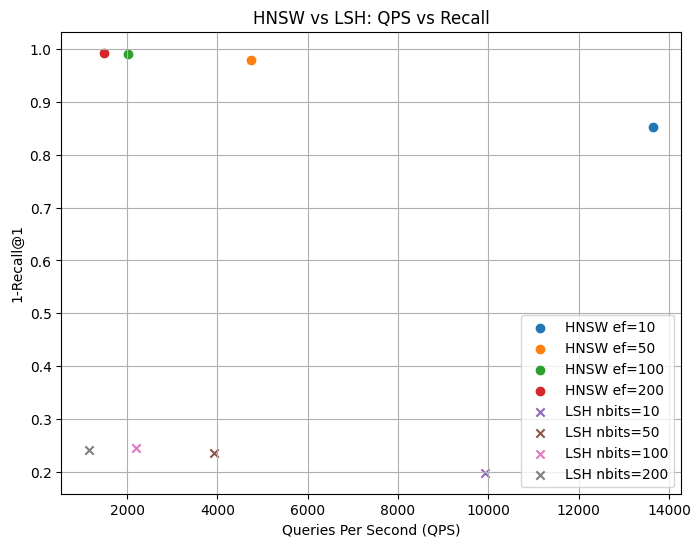

In [22]:

print(scann_results)
plot_results(hnsw_results, scann_results)